In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import warnings
import platform
import os

## 1. Data Loading


In [11]:
# Define file paths and model names
models = {
    'GPT-OSS-20B': 'intersection_metrics_gpt-oss-20B.csv',
    'SFT': 'intersection_metrics_GRPO_tuned.csv',
    'Qwen3-4B': 'intersection_metrics_qwen3_4B.csv',
    'Qwen3-30B-A3B': 'intersection_metrics_qwen3_30B_A3B.csv',
    'Max Pressure': 'intersection_metrics-最大压力算法.csv',
    'Last Round GRPO': 'intersection_metrics_GRPO.csv',
    'DeepSignal-4B': 'intersection_metrics_GRPO_new.csv',
    'LightGPT-8B-Llama3': 'intersection_metrics_LightGPT-8B-Llama3.csv'
}

# Load all data
data = {}
for model_name, file_path in models.items():
    try:
        df = pd.read_csv(file_path)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['model'] = model_name
        data[model_name] = df
        print(f"✓ Successfully loaded {model_name}: {len(df)} records")
    except Exception as e:
        print(f"✗ Failed to load {model_name}: {e}")

# Merge all data
all_data = pd.concat(data.values(), ignore_index=True)
print(f"\nTotal loaded {len(all_data)} records")


✓ Successfully loaded GPT-OSS-20B: 300 records
✓ Successfully loaded SFT: 300 records
✓ Successfully loaded Qwen3-4B: 300 records
✓ Successfully loaded Qwen3-30B-A3B: 300 records
✓ Successfully loaded Max Pressure: 376 records
✓ Successfully loaded Last Round GRPO: 300 records
✓ Successfully loaded DeepSignal-4B: 300 records
✓ Successfully loaded LightGPT-8B-Llama3: 300 records

Total loaded 2476 records


In [12]:
# View data overview
all_data.head()


,timestamp,traffic_light_id,average_saturation,total_vehicles,average_queue_length,max_saturation,max_queue_length,vehicle_throughput,congestion_index,congestion_level,model
0,2025-11-10 23:35:32.005867,J54,0.215625,42.0,8.4375,0.215625,8.4375,42.0,0.389414,基本畅通,GPT-OSS-20B
1,2025-11-10 23:35:43.208210,J54,0.156250,66.0,5.3125,0.156250,5.3125,66.0,0.302930,基本畅通,GPT-OSS-20B
2,2025-11-10 23:35:54.410225,J54,0.146875,87.0,5.6250,0.146875,5.6250,87.0,0.196797,非常畅通,GPT-OSS-20B
3,2025-11-10 23:36:05.625530,J54,0.156250,128.0,5.6250,0.156250,5.6250,128.0,0.236172,非常畅通,GPT-OSS-20B
4,2025-11-10 23:36:16.826646,J54,0.175000,160.0,7.5000,0.175000,7.5000,160.0,0.310000,基本畅通,GPT-OSS-20B


## 2. Key Metrics Statistics


In [13]:
# Calculate average metrics for each model
metrics_summary = all_data.groupby('model').agg({
    'average_saturation': 'mean',
    'average_queue_length': 'mean',
    'max_saturation': 'mean',
    'max_queue_length': 'mean',
    'vehicle_throughput': 'mean',
    'congestion_index': 'mean',
    'total_vehicles': 'sum'
}).round(4)

metrics_summary.columns = ['Avg Saturation', 'Avg Queue Length', 'Max Saturation', 'Max Queue Length', 'Avg Throughput', 'Avg Congestion Index', 'Total Vehicles']
metrics_summary = metrics_summary.sort_values('Avg Congestion Index')

print("\nPerformance Metrics Comparison by Model:")
print("=" * 120)
display(metrics_summary)

# Calculate congestion level distribution
congestion_dist = pd.crosstab(all_data['model'], all_data['congestion_level'], normalize='index') * 100
print("\nCongestion Level Distribution by Model (%):")
print("=" * 80)
display(congestion_dist.round(2))



Performance Metrics Comparison by Model:


,Avg Saturation,Avg Queue Length,Max Saturation,Max Queue Length,Avg Throughput,Avg Congestion Index,Total Vehicles
model,,,,,,,
Qwen3-30B-A3B,0.1663,5.8604,0.1663,5.8604,9288.6633,0.1625,2786599.0
DeepSignal-4B,0.1657,5.8301,0.1657,5.8301,9302.7960,0.1752,2790838.8
LightGPT-8B-Llama3,0.1538,5.7688,0.1538,5.7688,5510.2010,0.2086,1653060.3
SFT,0.1604,6.0021,0.1604,6.0021,5390.4867,0.2093,1617146.0
Last Round GRPO,0.1633,5.7090,0.1633,5.7090,9359.3267,0.2261,2807798.0
Qwen3-4B,0.2152,8.2083,0.2152,8.2083,7112.8433,0.2522,2133853.0
Max Pressure,0.2059,8.1034,0.2059,8.1034,7395.1463,0.2556,2780575.0
GPT-OSS-20B,0.2591,10.4292,0.2591,10.4292,8742.7267,0.3175,2622818.0



Congestion Level Distribution by Model (%):


congestion_level,基本畅通,轻度拥堵,非常畅通
model,,,
DeepSignal-4B,12.00,0.00,88.00
GPT-OSS-20B,53.33,2.00,44.67
Last Round GRPO,15.00,0.00,85.00
LightGPT-8B-Llama3,21.00,0.00,79.00
Max Pressure,36.44,0.00,63.56
Qwen3-30B-A3B,10.00,0.00,90.00
Qwen3-4B,32.00,2.33,65.67
SFT,23.33,0.00,76.67


## 3. Visualization Comparison Analysis

### 3.1 Key Metrics Comparison (Bar Chart)


✓ Chart saved: metrics_comparison_bars.png


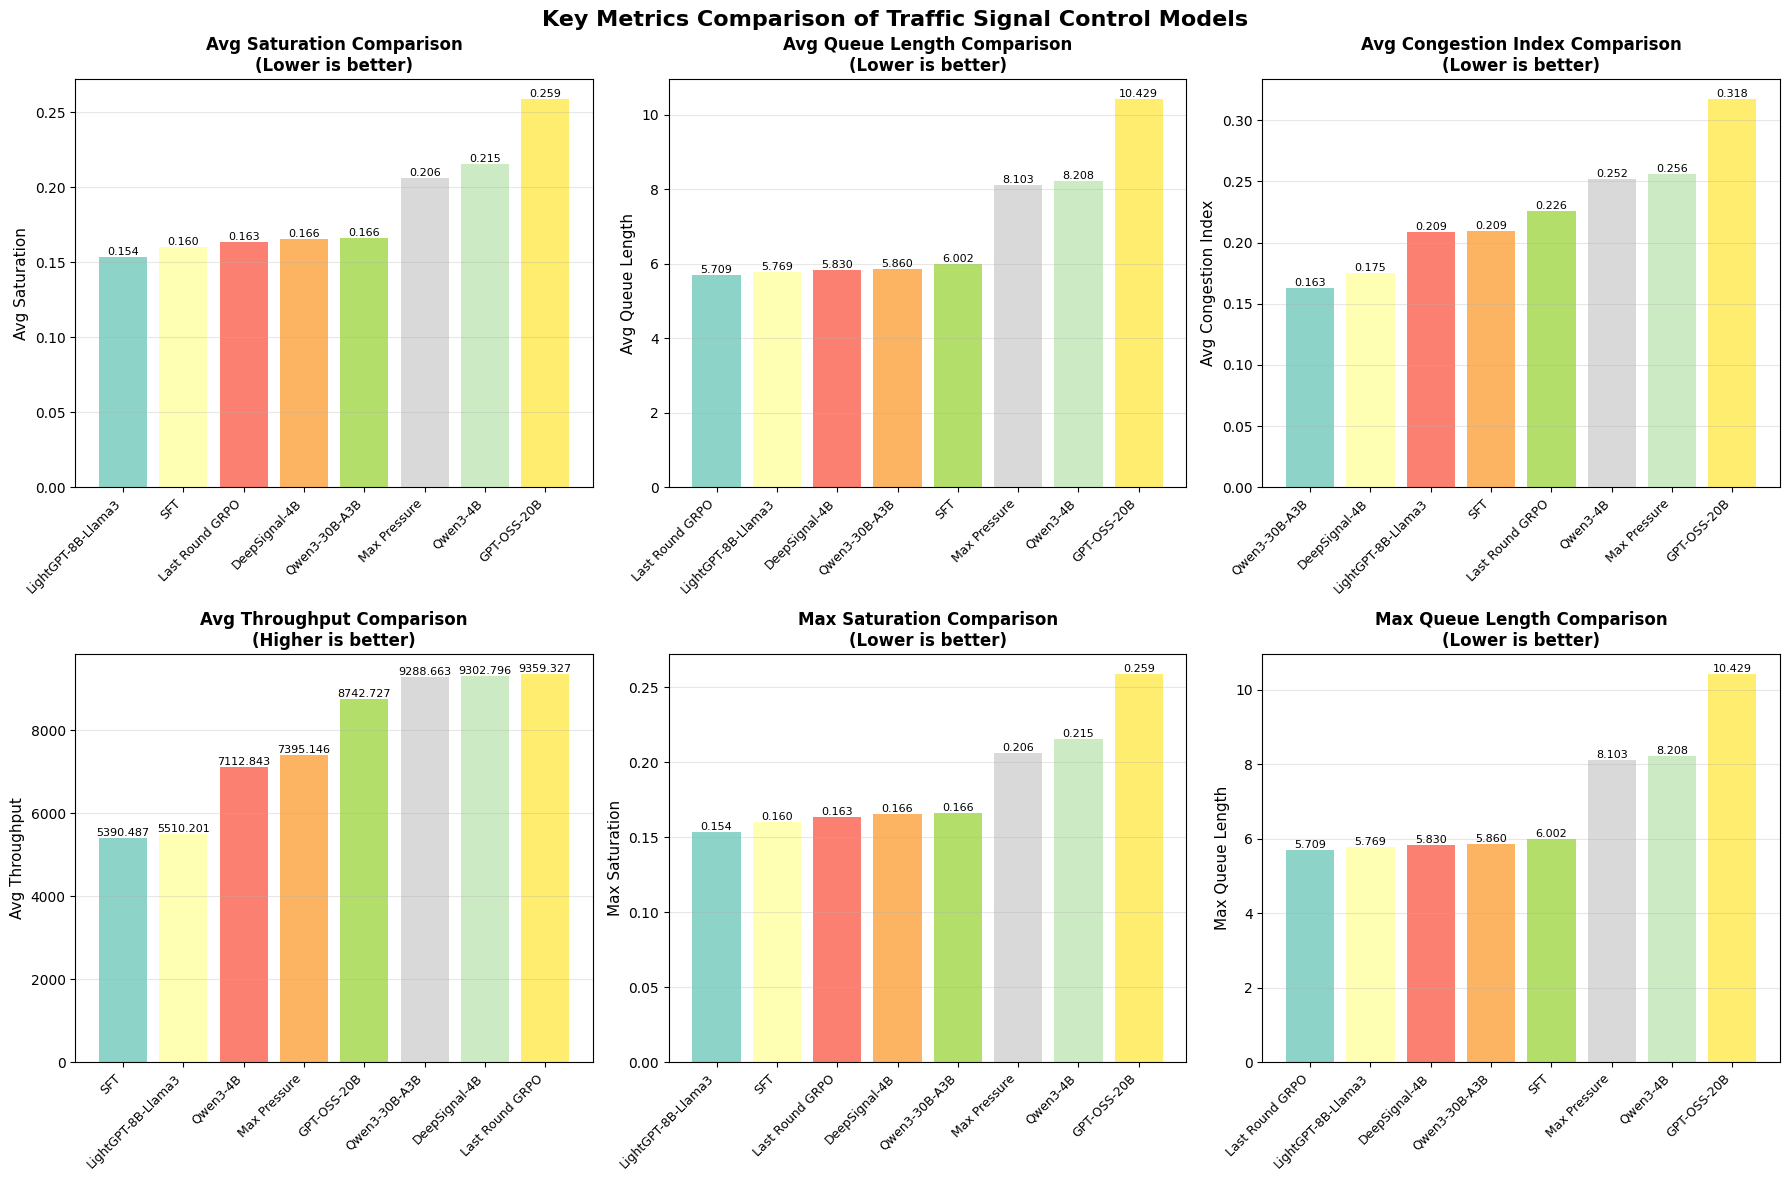

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

fig.suptitle('Key Metrics Comparison of Traffic Signal Control Models', fontsize=16, fontweight='bold')

# Metrics list
metrics = [
    ('Avg Saturation', 'average_saturation', 'Lower is better'),
    ('Avg Queue Length', 'average_queue_length', 'Lower is better'),
    ('Avg Congestion Index', 'congestion_index', 'Lower is better'),
    ('Avg Throughput', 'vehicle_throughput', 'Higher is better'),
    ('Max Saturation', 'max_saturation', 'Lower is better'),
    ('Max Queue Length', 'max_queue_length', 'Lower is better')
]

colors = plt.cm.Set3(np.linspace(0, 1, len(models)))

for idx, (title, col, note) in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    
    # Calculate average value for each model
    avg_values = all_data.groupby('model')[col].mean().sort_values()
    
    bars = ax.bar(range(len(avg_values)), avg_values.values, color=colors)
    ax.set_xticks(range(len(avg_values)))
    ax.set_xticklabels(avg_values.index, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel(title, fontsize=11)
    ax.set_title(f'{title} Comparison\n({note})', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('metrics_comparison_bars.png', dpi=300, bbox_inches='tight')
print("✓ Chart saved: metrics_comparison_bars.png")
plt.show()


### 3.2 Time Series Comparison


✓ Chart saved: metrics_timeseries.png


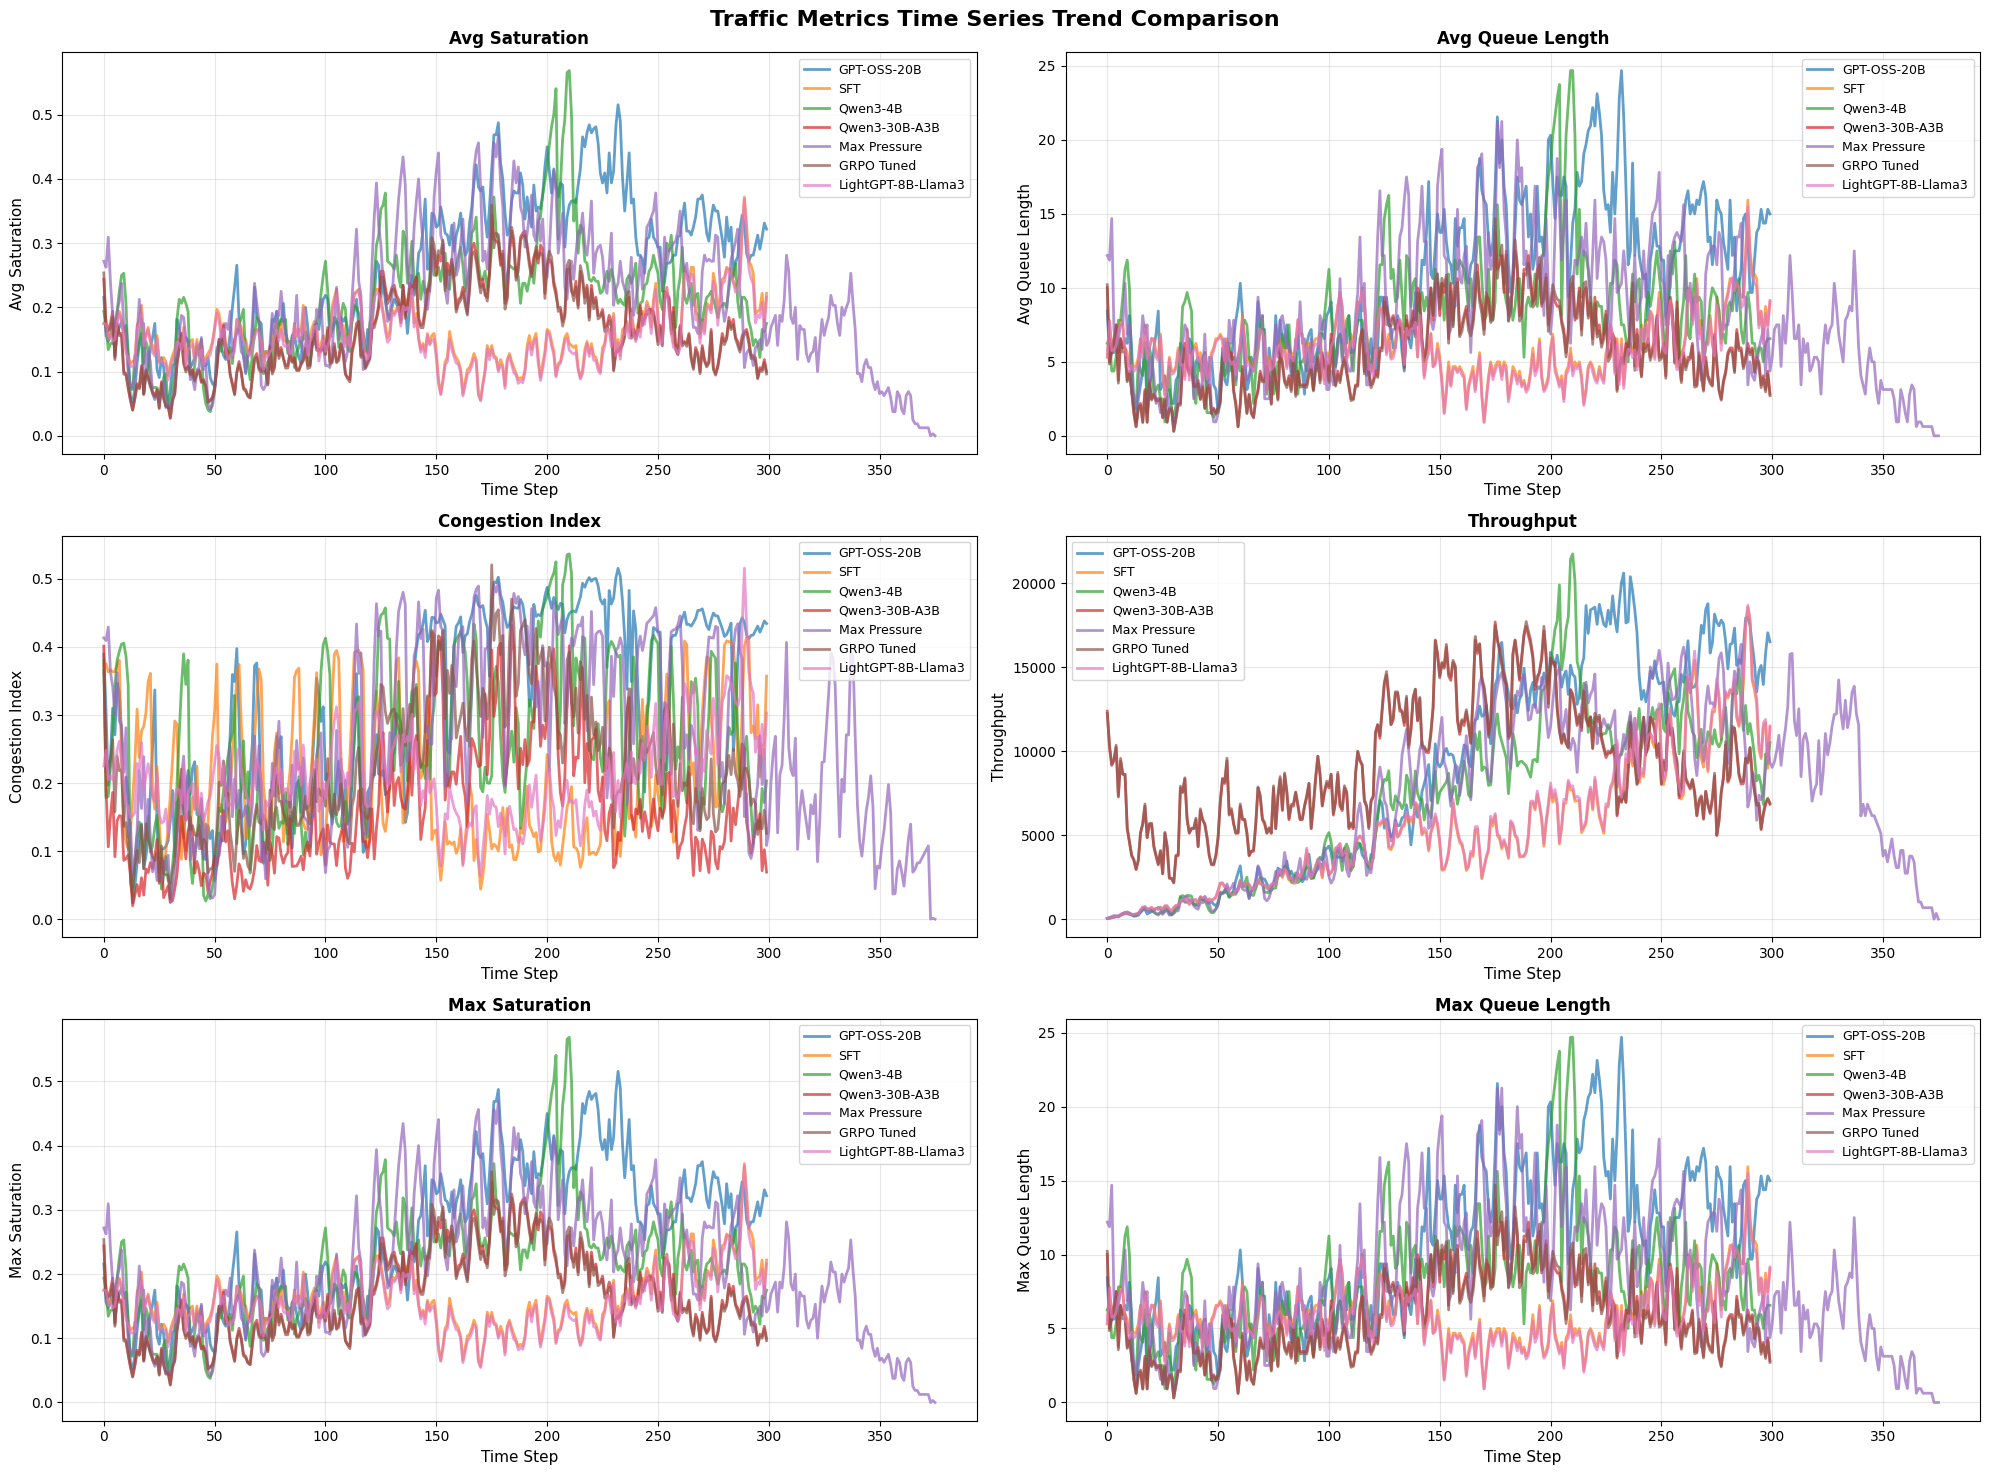

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

fig.suptitle('Traffic Metrics Time Series Trend Comparison', fontsize=16, fontweight='bold')

metrics_ts = [
    ('Avg Saturation', 'average_saturation'),
    ('Avg Queue Length', 'average_queue_length'),
    ('Congestion Index', 'congestion_index'),
    ('Throughput', 'vehicle_throughput'),
    ('Max Saturation', 'max_saturation'),
    ('Max Queue Length', 'max_queue_length')
]

for idx, (title, col) in enumerate(metrics_ts):
    ax = axes[idx // 2, idx % 2]
    
    for model_name, model_data in data.items():
        # Add time index for comparison
        model_data_sorted = model_data.sort_values('timestamp').reset_index(drop=True)
        # Use index instead of actual timestamp
        ax.plot(model_data_sorted.index, model_data_sorted[col], 
                label=model_name, alpha=0.7, linewidth=2)
    
    ax.set_xlabel('Time Step', fontsize=11)
    ax.set_ylabel(title, fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('metrics_timeseries.png', dpi=300, bbox_inches='tight')
print("✓ Chart saved: metrics_timeseries.png")
plt.show()


### 3.3 Congestion Level Distribution


/var/folders/3z/wdtcvnz52_1ffx0skvy0cyqm0000gn/T/ipykernel_50477/4131498594.py:28: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3z/wdtcvnz52_1ffx0skvy0cyqm0000gn/T/ipykernel_50477/4131498594.py:28: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3z/wdtcvnz52_1ffx0skvy0cyqm0000gn/T/ipykernel_50477/4131498594.py:28: UserWarning: Glyph 30021 (\N{CJK UNIFIED IDEOGRAPH-7545}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3z/wdtcvnz52_1ffx0skvy0cyqm0000gn/T/ipykernel_50477/4131498594.py:28: UserWarning: Glyph 36890 (\N{CJK UNIFIED IDEOGRAPH-901A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3z/wdtcvnz52_1ffx0skvy0cyqm0000gn/T/ipykernel_50477/4131498594.py:28: UserWarning: Glyph 36731 (\N{CJK UNIFIED IDEOGRAPH-8F7B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3z/wdtc

✓ Chart saved: congestion_level_distribution.png


/Users/leida/Cline/mcp_sumo_fastapi_llm/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/leida/Cline/mcp_sumo_fastapi_llm/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/leida/Cline/mcp_sumo_fastapi_llm/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30021 (\N{CJK UNIFIED IDEOGRAPH-7545}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/leida/Cline/mcp_sumo_fastapi_llm/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36890 (\N{CJK UNIFIED IDEOGRAPH-901A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/leida/Cline/mcp_sumo_fastapi_

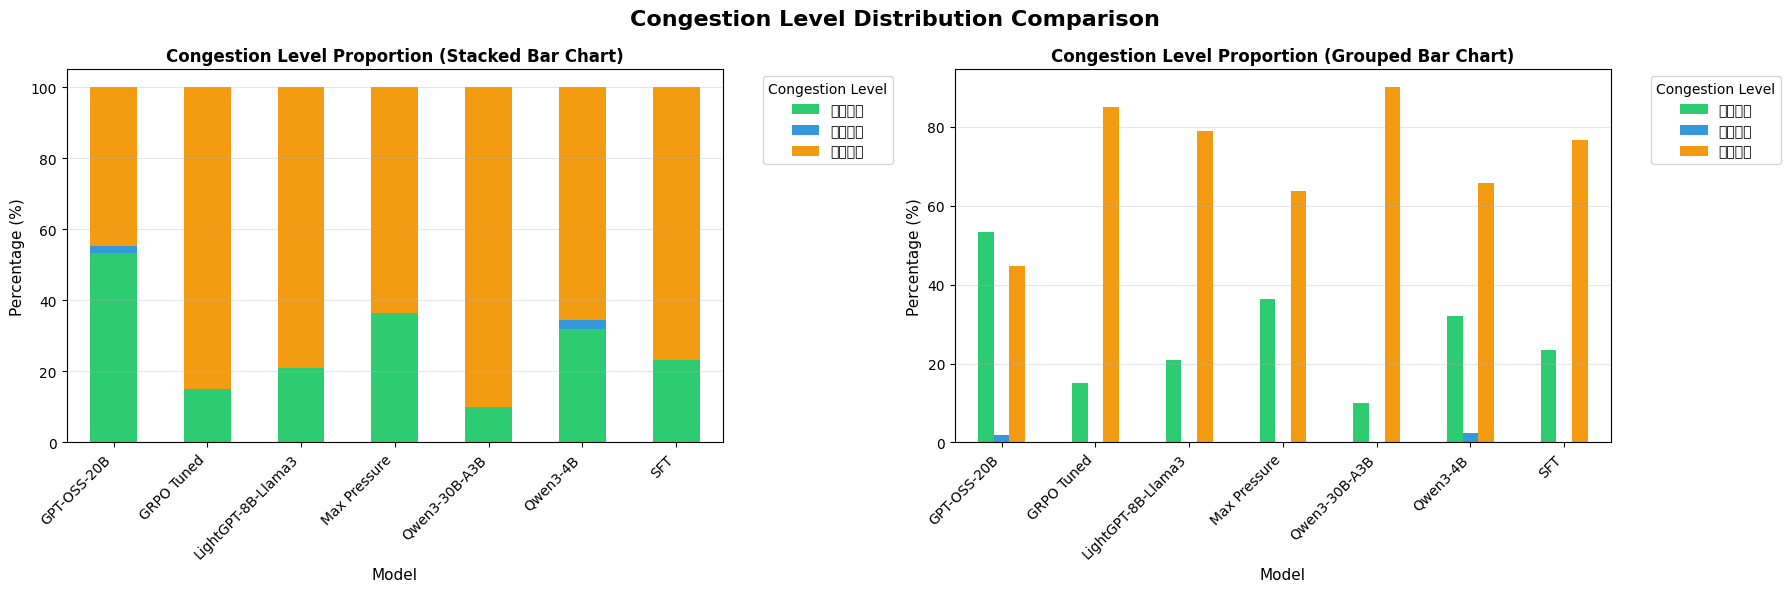

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

fig.suptitle('Congestion Level Distribution Comparison', fontsize=16, fontweight='bold')

# Stacked bar chart
congestion_counts = pd.crosstab(all_data['model'], all_data['congestion_level'])
congestion_pct = pd.crosstab(all_data['model'], all_data['congestion_level'], normalize='index') * 100

congestion_pct.plot(kind='bar', stacked=True, ax=ax1, 
                    color=['#2ecc71', '#3498db', '#f39c12', '#e74c3c'])
ax1.set_title('Congestion Level Proportion (Stacked Bar Chart)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Model', fontsize=11)
ax1.set_ylabel('Percentage (%)', fontsize=11)
legend1 = ax1.legend(title='Congestion Level', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Grouped bar chart
congestion_pct.plot(kind='bar', ax=ax2, 
                    color=['#2ecc71', '#3498db', '#f39c12', '#e74c3c'])
ax2.set_title('Congestion Level Proportion (Grouped Bar Chart)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Model', fontsize=11)
ax2.set_ylabel('Percentage (%)', fontsize=11)
legend2 = ax2.legend(title='Congestion Level', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('congestion_level_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Chart saved: congestion_level_distribution.png")
plt.show()


### 3.4 Box Plot Comparison (Distribution Features)


/var/folders/3z/wdtcvnz52_1ffx0skvy0cyqm0000gn/T/ipykernel_50477/1725071116.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=models.keys(), patch_artist=True)
/var/folders/3z/wdtcvnz52_1ffx0skvy0cyqm0000gn/T/ipykernel_50477/1725071116.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=models.keys(), patch_artist=True)
/var/folders/3z/wdtcvnz52_1ffx0skvy0cyqm0000gn/T/ipykernel_50477/1725071116.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=models.keys(), patch_artist=True)
/var/folders/3z/wdtcvnz52_1ffx0skvy0c

✓ 图表已保存: metrics_boxplot.png


/Users/leida/Cline/mcp_sumo_fastapi_llm/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/leida/Cline/mcp_sumo_fastapi_llm/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/leida/Cline/mcp_sumo_fastapi_llm/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39281 (\N{CJK UNIFIED IDEOGRAPH-9971}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/leida/Cline/mcp_sumo_fastapi_llm/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/leida/Cline/mcp_sumo_fastapi_

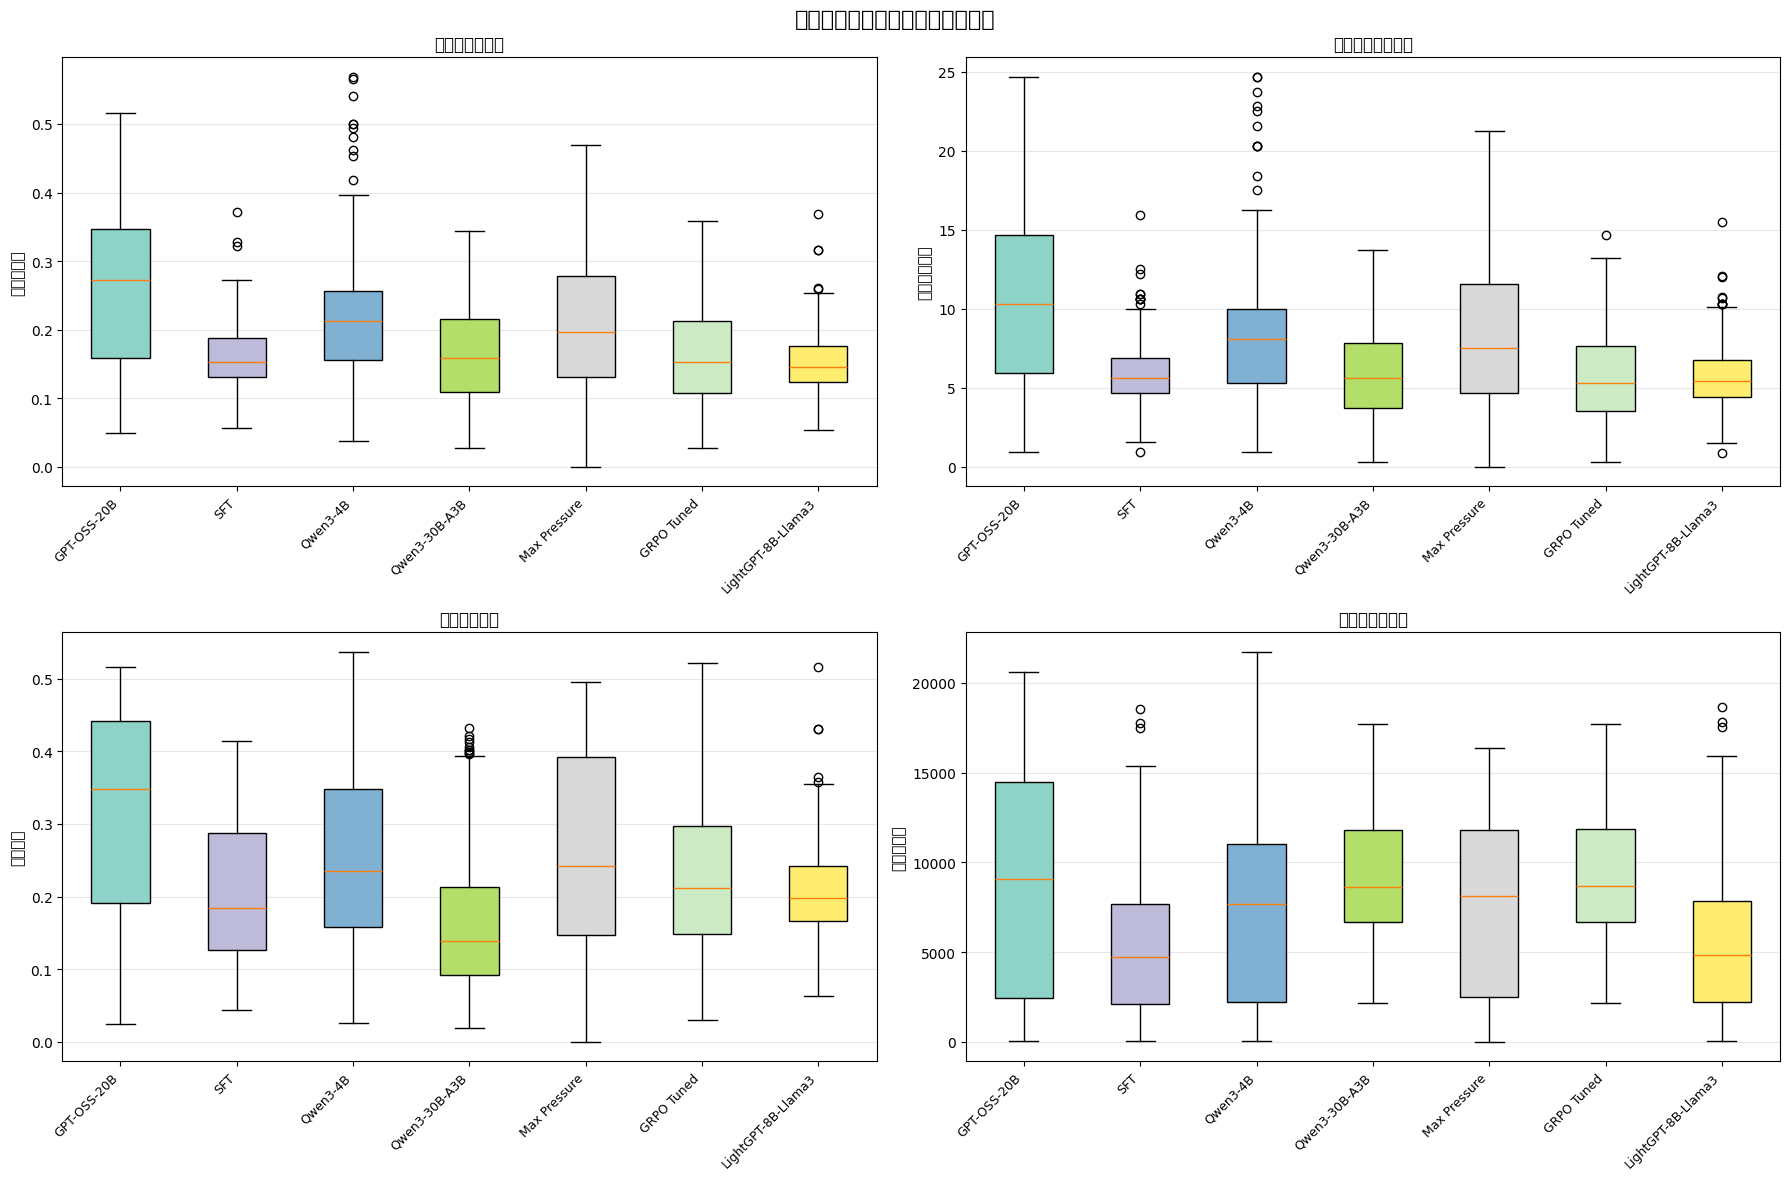

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

fig.suptitle('交通指标分布特征对比（箱线图）', fontsize=16, fontweight='bold')

box_metrics = [
    ('平均饱和度', 'average_saturation'),
    ('平均队列长度', 'average_queue_length'),
    ('拥堵指数', 'congestion_index'),
    ('车辆吞吐量', 'vehicle_throughput')
]

for idx, (title, col) in enumerate(box_metrics):
    ax = axes[idx // 2, idx % 2]
    
    # 创建箱线图数据
    box_data = [data[model][col].dropna() for model in models.keys()]
    
    bp = ax.boxplot(box_data, labels=models.keys(), patch_artist=True)
    
    # 设置颜色
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_ylabel(title, fontsize=11)
    ax.set_title(f'{title}分布', fontsize=12, fontweight='bold')
    ax.set_xticklabels(models.keys(), rotation=45, ha='right', fontsize=9)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('metrics_boxplot.png', dpi=300, bbox_inches='tight')
print("✓ 图表已保存: metrics_boxplot.png")
plt.show()


In [ ]:
from math import pi
from matplotlib.font_manager import FontProperties


# 准备雷达图数据（归一化到0-1）
radar_metrics = ['平均饱和度', '平均队列长度', '最大饱和度', '最大队列长度', '拥堵指数']
radar_cols = ['average_saturation', 'average_queue_length', 'max_saturation', 'max_queue_length', 'congestion_index']

# 计算每个模型的平均值
radar_data = {}
for model_name in models.keys():
    values = []
    for col in radar_cols:
        val = data[model_name][col].mean()
        # 归一化（对于这些指标，越小越好，所以用1减去归一化值）
        max_val = all_data[col].max()
        min_val = all_data[col].min()
        normalized = 1 - (val - min_val) / (max_val - min_val) if max_val != min_val else 0.5
        values.append(normalized)
    radar_data[model_name] = values

# 创建雷达图
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='polar')

# 设置角度
angles = [n / float(len(radar_metrics)) * 2 * pi for n in range(len(radar_metrics))]
angles += angles[:1]

# 绘制每个模型
for idx, (model_name, values) in enumerate(radar_data.items()):
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

# 设置标签
ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_metrics, fontsize=11)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=9)
ax.grid(True)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
plt.title('模型综合性能雷达图\n（越接近外圈越好）', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('radar_chart.png', dpi=300, bbox_inches='tight')
print("✓ 图表已保存: radar_chart.png")
plt.show()


### 3.6 综合性能评分

In [ ]:
# 计算综合评分（越小的指标越好）
score_weights = {
    'average_saturation': -0.25,      # 越小越好
    'average_queue_length': -0.25,    # 越小越好
    'congestion_index': -0.30,        # 越小越好
    'vehicle_throughput': 0.20        # 越大越好
}

scores = {}
for model_name in models.keys():
    score = 0
    for metric, weight in score_weights.items():
        # 归一化
        max_val = all_data[metric].max()
        min_val = all_data[metric].min()
        val = data[model_name][metric].mean()
        normalized = (val - min_val) / (max_val - min_val) if max_val != min_val else 0.5
        score += weight * normalized
    scores[model_name] = score

# 转换为0-100分
min_score = min(scores.values())
max_score = max(scores.values())
scores_100 = {k: 100 - (v - min_score) / (max_score - min_score) * 100 for k, v in scores.items()}

# 排序
scores_sorted = sorted(scores_100.items(), key=lambda x: x[1], reverse=True)

# 绘图
fig, ax = plt.subplots(figsize=(12, 6))
models_names = [x[0] for x in scores_sorted]
scores_values = [x[1] for x in scores_sorted]

bars = ax.barh(models_names, scores_values, color=plt.cm.RdYlGn(np.array(scores_values)/100))
ax.set_xlabel('综合评分', fontsize=12)
ax.set_title('模型综合性能评分（0-100分）', fontsize=14, fontweight='bold')
ax.set_xlim(0, 100)
ax.grid(axis='x', alpha=0.3)

# 添加数值标签
for i, (bar, score) in enumerate(zip(bars, scores_values)):
    ax.text(score + 1, i, f'{score:.2f}分', 
            va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('overall_score.png', dpi=300, bbox_inches='tight')
plt.show()

# 打印排名
print("\n模型综合性能排名：")
print("=" * 50)
for i, (model, score) in enumerate(scores_sorted, 1):
    print(f"{i}. {model:20s} {score:.2f}分")


In [ ]:
# 详细统计信息
print("\n各模型详细统计信息：")
print("=" * 120)

for model_name in models.keys():
    print(f"\n{model_name}:")
    print("-" * 120)
    stats = data[model_name][['average_saturation', 'average_queue_length', 
                               'congestion_index', 'vehicle_throughput']].describe()
    display(stats.T)


## 5. 结论与建议

In [ ]:
print("\n" + "=" * 80)
print("主要发现：")
print("=" * 80)

# 找出各指标的最佳模型
best_models = {
    '最低平均饱和度': metrics_summary['平均饱和度'].idxmin(),
    '最低平均队列长度': metrics_summary['平均队列长度'].idxmin(),
    '最低拥堵指数': metrics_summary['平均拥堵指数'].idxmin(),
    '最高车辆吞吐量': metrics_summary['平均吞吐量'].idxmax(),
    '综合性能最佳': scores_sorted[0][0]
}

for metric, model in best_models.items():
    print(f"• {metric}: {model}")

print(f"\n综合评分前三名：")
for i in range(min(3, len(scores_sorted))):
    print(f"{i+1}. {scores_sorted[i][0]}: {scores_sorted[i][1]:.2f}分")

print("\n" + "=" * 80)
